In [1]:
import os
from scipy.io import loadmat
import h5py

import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Load mat file data
mat = h5py.File(os.path.join("NYUv2", "nyu_depth_v2_labeled.mat"), 'r', libver='latest', swmr=True)

# Images are in 4D array (1449, 3, 640, 480), and depth maps are in 3D array (1449, 640, 480).
# We can simply transpose the axes to get them in a format suitable for training.

images = np.transpose(mat["images"], (0, 2, 3, 1))
depths = np.transpose(mat["depths"], (0, 2, 1))

# Shuffle data
indices = np.arange(images.shape[0])
np.random.shuffle(indices)
images = images[indices]
depths = depths[indices]

# Split data into training and validation
train_images = images[:1000]
train_depths = depths[:1000]
val_images = images[1000:]
val_depths = depths[1000:]

In [2]:
def crop_images(images, percentage):
    # The percentage should be between 0 and 1
    height, width = images.shape[1], images.shape[2]
    start_row = int(height * percentage / 2)
    end_row = height - start_row
    start_col = int(width * percentage / 2)
    end_col = width - start_col
    return images[:, start_row:end_row, start_col:end_col, :]

percentage = 0.30  

# Crop training images
train_images = crop_images(train_images, percentage)
val_images = crop_images(val_images, percentage)


In [6]:
print(train_images[0].shape)

(448, 336, 3)


In [4]:
# Extract depth value at the center
center_depths_train = train_depths[:, 320, 240]
center_depths_val = val_depths[:, 320, 240]

# normalize images for better network performance
train_images = train_images / 255.
val_images = val_images / 255.

# Reshape depths for suitable training 
center_depths_train = center_depths_train.reshape(-1, 1)
center_depths_val = center_depths_val.reshape(-1, 1)

In [8]:
import tensorflow as tf
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

# define the input shape based on your data
input_shape = train_images.shape[1:]

# load the pre-trained MobileNet model, excluding the top layer
base_model = MobileNet(input_shape=input_shape, weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

# we add a fully-connected layer
x = Dense(1024, activation='relu')(x)

# we add the output layer to output depth value
output_layer = Dense(1)(x)

# define the model
model = Model(inputs=base_model.input, outputs=output_layer)


17225924/17225924 [==============================] - 1s 0us/step


In [10]:
# freeze the base MobileNet model
for layer in base_model.layers:
    layer.trainable = False

# compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# train the model
history = model.fit(train_images, center_depths_train, validation_data=(val_images, center_depths_val), epochs=20, batch_size=64)

Epoch 1/20
16/16 [==============================] - 4s 185ms/step - loss: 1.4563 - val_loss: 1.0190
Epoch 2/20
16/16 [==============================] - 2s 115ms/step - loss: 0.7060 - val_loss: 0.7773
Epoch 3/20
16/16 [==============================] - 2s 113ms/step - loss: 0.5692 - val_loss: 0.7510
Epoch 4/20
16/16 [==============================] - 2s 114ms/step - loss: 0.5356 - val_loss: 0.7545
Epoch 5/20
16/16 [==============================] - 2s 116ms/step - loss: 0.5125 - val_loss: 0.7836
Epoch 6/20
16/16 [==============================] - 2s 116ms/step - loss: 0.5092 - val_loss: 0.7818
Epoch 7/20
16/16 [==============================] - 2s 113ms/step - loss: 0.5113 - val_loss: 0.7546
Epoch 8/20
16/16 [==============================] - 2s 116ms/step - loss: 0.4550 - val_loss: 0.7644
Epoch 9/20
16/16 [==============================] - 2s 115ms/step - loss: 0.4518 - val_loss: 0.9230
Epoch 10/20
16/16 [==============================] - 2s 116ms/step - loss: 0.4558 - val_loss: 0.7780

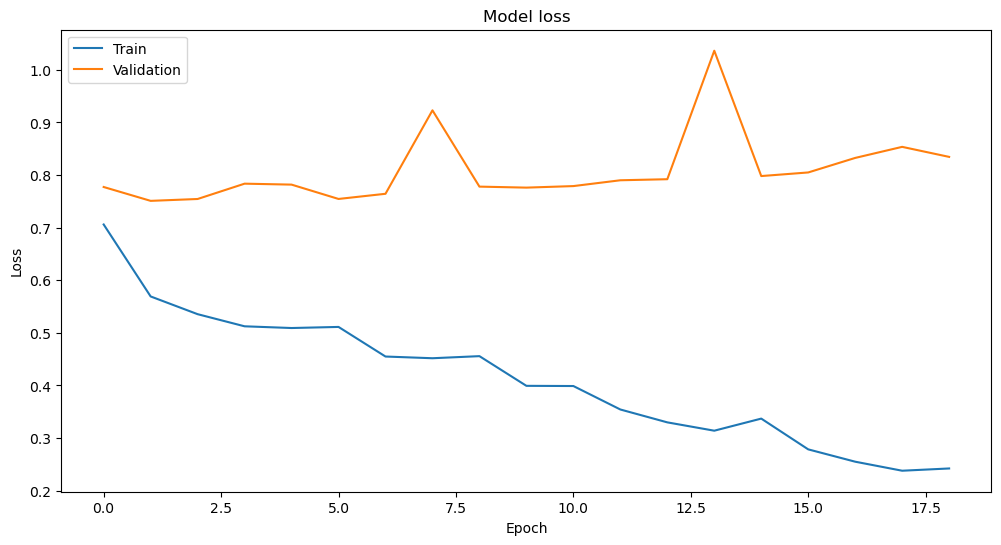

In [11]:
# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'][1:])
plt.plot(history.history['val_loss'][1:])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [12]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Predicting the distances on the validation set
val_predictions = model.predict(val_images)

# Reshaping predictions and true values to one-dimensional arrays
val_predictions = val_predictions.reshape(-1)
true_values = center_depths_val.reshape(-1)

# Calculate Mean Absolute Error
mae = mean_absolute_error(true_values, val_predictions)
print(f"Mean Absolute Error (MAE): {mae} meters")

# Calculate Mean Squared Error
mse = mean_squared_error(true_values, val_predictions)
print(f"Mean Squared Error (MSE): {mse} meters")


15/15 [==============================] - 1s 35ms/step
Mean Absolute Error (MAE): 0.7056496143341064 meters
Mean Squared Error (MSE): 0.8345335721969604 meters


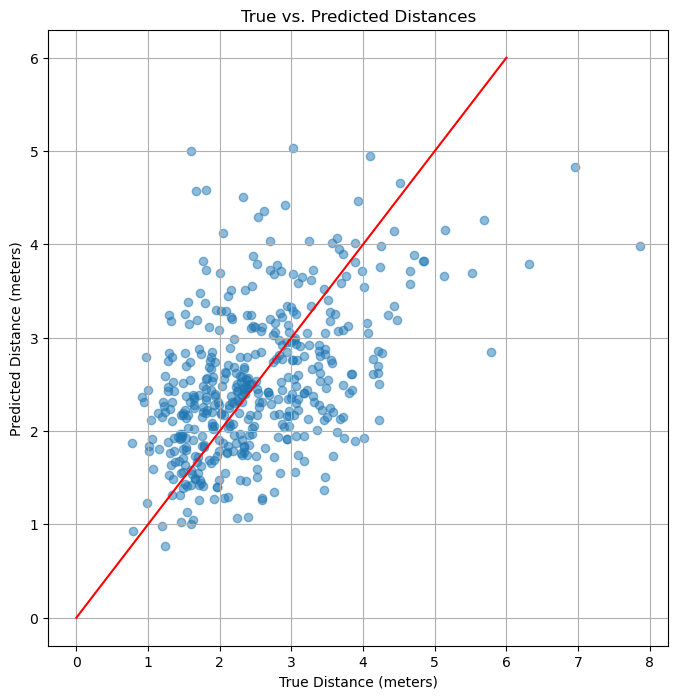

In [13]:
import matplotlib.pyplot as plt

# Scatter plot of true vs. predicted distances
plt.figure(figsize=(8, 8))
plt.scatter(true_values, val_predictions, alpha=0.5)
plt.plot([0, 6], [0, 6], color='red')  # Ideal model would follow this line
plt.xlabel('True Distance (meters)')
plt.ylabel('Predicted Distance (meters)')
plt.title('True vs. Predicted Distances')
plt.grid(True)
plt.show()


In [18]:
# Choose the number of top layers to freeze
# In this case, let's freeze all but the top 20 layers
fine_tune_at = len(base_model.layers) - 1

# Unfreeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

# For the rest of the layers, set them as trainable
for layer in base_model.layers[fine_tune_at:]:
    layer.trainable = True

# Compile the model with a low learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),  # Low learning rate
              loss='mean_squared_error')

# Train end-to-end. Be careful to stop before you overfit!
history = model.fit(train_images, center_depths_train,
                              validation_data=(val_images, center_depths_val),
                              epochs=10, batch_size=32)


Epoch 1/10
32/32 [==============================] - 4s 98ms/step - loss: 0.0509 - val_loss: 0.9019
Epoch 2/10
32/32 [==============================] - 2s 60ms/step - loss: 0.0504 - val_loss: 0.9035
Epoch 3/10
32/32 [==============================] - 2s 60ms/step - loss: 0.0493 - val_loss: 0.9041
Epoch 4/10
32/32 [==============================] - 2s 59ms/step - loss: 0.0487 - val_loss: 0.9088
Epoch 5/10
32/32 [==============================] - 2s 60ms/step - loss: 0.0482 - val_loss: 0.9052
Epoch 6/10
32/32 [==============================] - 2s 61ms/step - loss: 0.0478 - val_loss: 0.9056
Epoch 7/10
32/32 [==============================] - 2s 60ms/step - loss: 0.0472 - val_loss: 0.9035
Epoch 8/10
32/32 [==============================] - 2s 61ms/step - loss: 0.0474 - val_loss: 0.9043
Epoch 9/10
32/32 [==============================] - 2s 61ms/step - loss: 0.0465 - val_loss: 0.9040
Epoch 10/10
32/32 [==============================] - 2s 58ms/step - loss: 0.0461 - val_loss: 0.9075


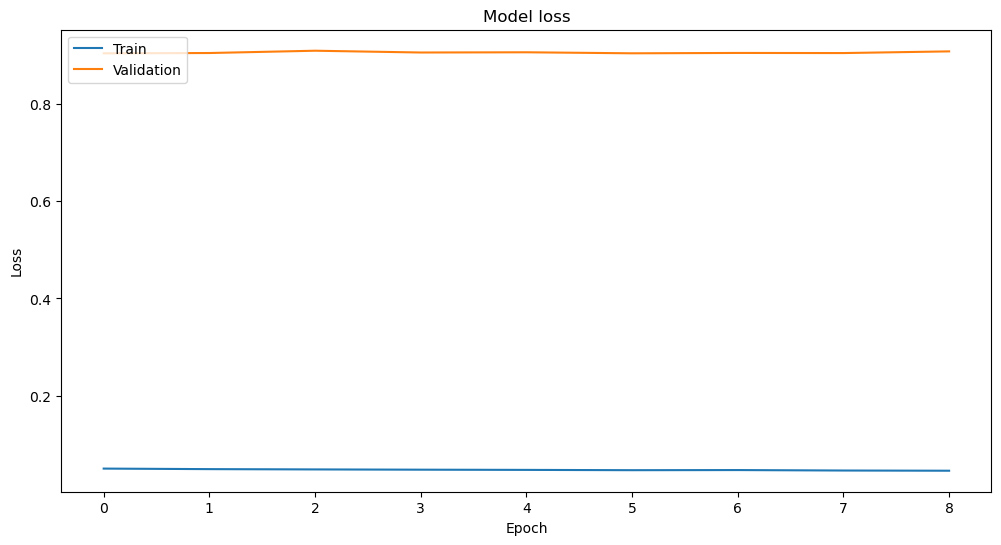

In [19]:
# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'][1:])
plt.plot(history.history['val_loss'][1:])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [20]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Predicting the distances on the validation set
val_predictions = model.predict(val_images)

# Reshaping predictions and true values to one-dimensional arrays
val_predictions = val_predictions.reshape(-1)
true_values = center_depths_val.reshape(-1)

# Calculate Mean Absolute Error
mae = mean_absolute_error(true_values, val_predictions)
print(f"Mean Absolute Error (MAE): {mae} meters")

# Calculate Mean Squared Error
mse = mean_squared_error(true_values, val_predictions)
print(f"Mean Squared Error (MSE): {mse} meters")

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

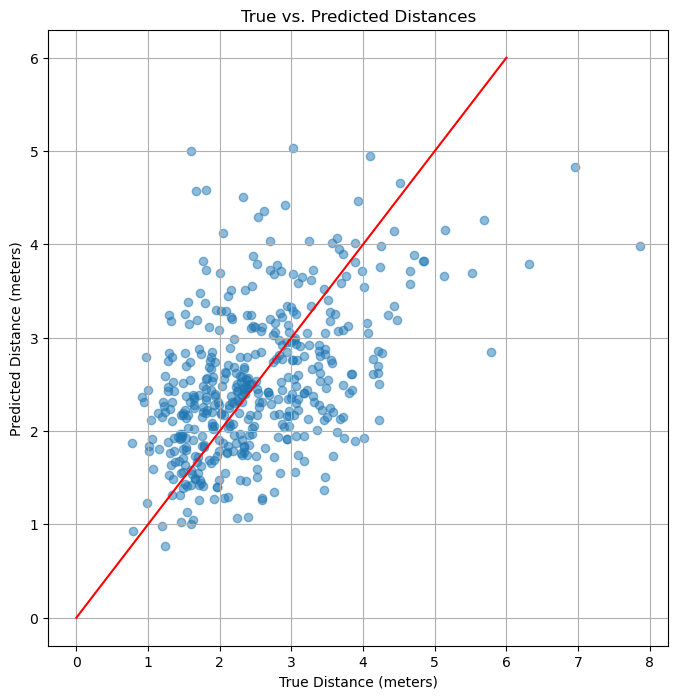

In [21]:
import matplotlib.pyplot as plt

# Scatter plot of true vs. predicted distances
plt.figure(figsize=(8, 8))
plt.scatter(true_values, val_predictions, alpha=0.5)
plt.plot([0, 6], [0, 6], color='red')  # Ideal model would follow this line
plt.xlabel('True Distance (meters)')
plt.ylabel('Predicted Distance (meters)')
plt.title('True vs. Predicted Distances')
plt.grid(True)
plt.show()
